Epoch 0000 | Loss: 1.0198e+01 | LR: 1.00e-03
Epoch 0050 | Loss: 1.0480e-01 | LR: 1.00e-03
Epoch 0100 | Loss: 3.4365e-02 | LR: 1.00e-03
Epoch 0150 | Loss: 2.4049e-02 | LR: 1.00e-03
Epoch 0200 | Loss: 1.8838e-02 | LR: 1.00e-03
Epoch 0250 | Loss: 1.5280e-02 | LR: 1.00e-03
Epoch 0300 | Loss: 1.2462e-02 | LR: 1.00e-03
Epoch 0350 | Loss: 9.9931e-03 | LR: 1.00e-03
Epoch 0400 | Loss: 7.7783e-03 | LR: 1.00e-03
[Epoch 427] Loss stagnated. Reducing learning rate to 1.00e-04
Epoch 0450 | Loss: 8.7625e-03 | LR: 1.00e-04
Epoch 0500 | Loss: 6.9086e-03 | LR: 1.00e-04
[Epoch 538] Loss stagnated. Reducing learning rate to 1.00e-05
Epoch 0550 | Loss: 6.9892e-03 | LR: 1.00e-05
[Epoch 558] Loss stagnated. Reducing learning rate to 1.00e-06
[Epoch 578] Loss stagnated. Reducing learning rate to 1.00e-07
[Epoch 598] Loss stagnated. Reducing learning rate to 1.00e-08
Epoch 0600 | Loss: 7.4089e-03 | LR: 1.00e-08
[Epoch 618] Loss stagnated. Reducing learning rate to 1.00e-09
[Epoch 638] Loss stagnated. Reducing 

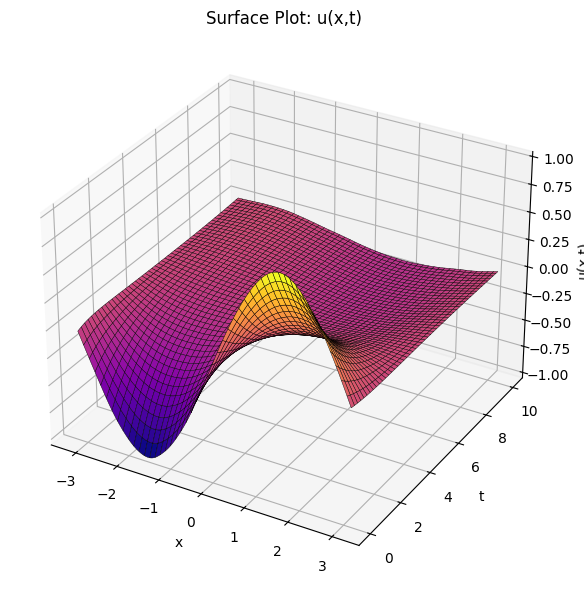

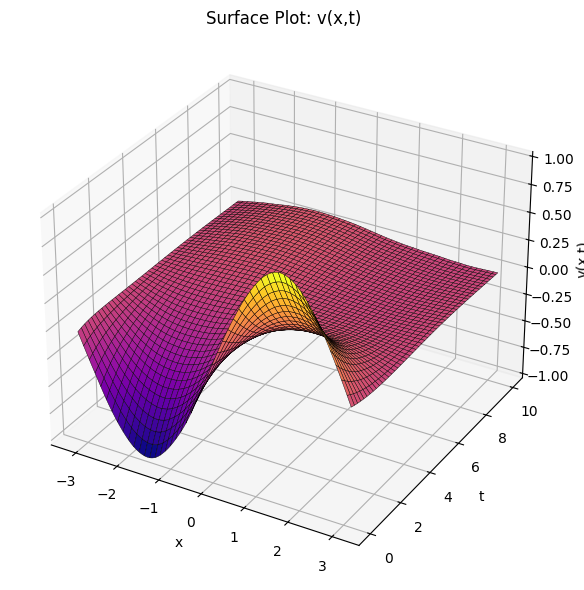

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----- Device and Constants -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 1.0
pi = np.pi
tmin, tmax = 0.0, 10.0
xmin, xmax = -pi, pi
lb = torch.tensor([tmin, xmin], dtype=torch.float32, device=device)
ub = torch.tensor([tmax, xmax], dtype=torch.float32, device=device)

# ----- Fourier Feature Mapping -----
def fourier_features(x, freqs=[1, 2, 4, 8]):
    out = [x]
    for w in freqs:
        out += [torch.sin(w * x), torch.cos(w * x)]
    return torch.cat(out, dim=1)

def scale_input(x):
    return 2.0 * (x - lb) / (ub - lb) - 1.0

# ----- Network Architecture with Residual Blocks -----
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResidualBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.linear = nn.Linear(width, width)
        self.activation = Swish()

    def forward(self, x):
        return x + self.activation(self.linear(x))

class CoupledNet(nn.Module):
    def __init__(self, in_dim, width=100, depth=8):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, width)
        self.hidden = nn.Sequential(*[ResidualBlock(width) for _ in range(depth)])
        self.output_layer = nn.Linear(width, 2)

    def forward(self, x):
        x = Swish()(self.input_layer(x))
        x = self.hidden(x)
        return self.output_layer(x).split(1, dim=1)

# ----- Physics-Informed Residuals -----
def residuals(model, X_r):
    X_r.requires_grad_(True)
    t, x = X_r[:, 0:1], X_r[:, 1:2]
    x_input = torch.cat([t, fourier_features(x)], dim=1)
    u, v = model(x_input)

    grads_u = torch.autograd.grad(u, X_r, torch.ones_like(u), create_graph=True)[0]
    grads_v = torch.autograd.grad(v, X_r, torch.ones_like(v), create_graph=True)[0]

    u_t, u_x = grads_u[:, 0:1], grads_u[:, 1:2]
    v_t, v_x = grads_v[:, 0:1], grads_v[:, 1:2]

    u_xx = torch.autograd.grad(u_x, X_r, torch.ones_like(u_x), create_graph=True)[0][:, 1:2]
    v_xx = torch.autograd.grad(v_x, X_r, torch.ones_like(v_x), create_graph=True)[0][:, 1:2]

    uv = u * v
    uv_x = torch.autograd.grad(uv, X_r, torch.ones_like(uv), create_graph=True)[0][:, 1:2]

    r1 = u_t - epsilon * u_xx - 2 * u * u_x + uv_x
    r2 = v_t - epsilon * v_xx - 2 * v * v_x + uv_x

    return r1, r2

# ----- Initial and Boundary Conditions -----
def u_exact(x, t):
    return torch.exp(-t) * torch.sin(x)

def v_exact(x, t):
    return torch.exp(-t) * torch.sin(x)

def generate_data(N_0=100, N_b=100, N_r=10000):
    x_0 = (xmax - xmin) * torch.rand((N_0, 1), device=device) + xmin
    t_0 = torch.full_like(x_0, tmin)
    X_0 = torch.cat([t_0, x_0], dim=1)
    u_0 = u_exact(x_0, t_0)
    v_0 = v_exact(x_0, t_0)

    t_b = (tmax - tmin) * torch.rand((N_b, 1), device=device) + tmin
    x_b0 = torch.full_like(t_b, xmin)
    x_b1 = torch.full_like(t_b, xmax)
    X_b = torch.cat([torch.cat([t_b, x_b0], dim=1), torch.cat([t_b, x_b1], dim=1)], dim=0)
    u_b = u_exact(X_b[:, 1:2], X_b[:, 0:1])
    v_b = v_exact(X_b[:, 1:2], X_b[:, 0:1])

    t_r = (tmax - tmin) * torch.rand((N_r, 1), device=device) + tmin
    x_r = (xmax - xmin) * torch.rand((N_r, 1), device=device) + xmin
    X_r = torch.cat([t_r, x_r], dim=1)

    return X_0, u_0, v_0, X_b, u_b, v_b, X_r

# ----- Loss Function -----
def loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b, epoch=0, max_epoch=10000):
    r1, r2 = residuals(model, X_r)
    w_pde = 0.1 + 0.9 * (epoch / max_epoch)

    loss_pde = torch.mean(r1**2) + torch.mean(r2**2)
    x0_input = torch.cat([X_0[:, 0:1], fourier_features(X_0[:, 1:2])], dim=1)
    xb_input = torch.cat([X_b[:, 0:1], fourier_features(X_b[:, 1:2])], dim=1)

    u_pred_0, v_pred_0 = model(x0_input)
    u_pred_b, v_pred_b = model(xb_input)

    loss_ic = torch.mean((u_pred_0 - u_0)**2 + (v_pred_0 - v_0)**2)
    loss_bc = torch.mean((u_pred_b - u_b)**2 + (v_pred_b - v_b)**2)

    return loss_ic + loss_bc + w_pde * loss_pde

# ----- Training Function -----
def train_model(model, data, epochs=2500, patience=300, lr=1e-3):
    X_0, u_0, v_0, X_b, u_b, v_b, X_r = data
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
    best_loss, best_state, patience_counter = float('inf'), None, 0

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, X_r, X_0, u_0, v_0, X_b, u_b, v_b, epoch, epochs)
        loss.backward(); optimizer.step(); scheduler.step()

        if loss.item() < best_loss - 1e-10:  # some tolerance to prevent premature stagnation
            best_loss, best_state, patience_counter = loss.item(), model.state_dict(), 0
        else:
            patience_counter += 1

        if patience_counter % 20 == 0 and patience_counter > 0:
            for g in optimizer.param_groups:
                g['lr'] /= 10  # Reduce LR on stagnation
            print(f"[Epoch {epoch}] Loss stagnated. Reducing learning rate to {optimizer.param_groups[0]['lr']:.2e}")

        if epoch % 50 == 0:
            print(f"Epoch {epoch:04d} | Loss: {loss.item():.4e} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        if patience_counter > patience:
            print("Early stopping at epoch", epoch)
            break

    model.load_state_dict(best_state)
    return model

# ----- Prediction and Evaluation -----
def predict(model, t_eval=tmax, N=200):
    x = torch.linspace(xmin, xmax, N, device=device).reshape(-1, 1)
    t = torch.full_like(x, t_eval)
    X = torch.cat([t, x], dim=1)
    with torch.no_grad():
        x_input = torch.cat([t, fourier_features(x)], dim=1)
        u_pred, v_pred = model(x_input)
        u_true, v_true = u_exact(x, t), v_exact(x, t)
    return x.cpu().numpy(), u_pred.cpu().numpy(), v_pred.cpu().numpy(), u_true.cpu().numpy(), v_true.cpu().numpy()

# ----- Surface Plotting -----
def plot_surface(model, label='u'):
    x_vals = torch.linspace(xmin, xmax, 200, device=device)
    t_vals = torch.linspace(tmin, tmax, 200, device=device)
    X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')
    XT = torch.cat([T.reshape(-1, 1), X.reshape(-1, 1)], dim=1)
    with torch.no_grad():
        X_input = torch.cat([XT[:, 0:1], fourier_features(XT[:, 1:2])], dim=1)
        u_pred, v_pred = model(X_input)
    U = u_pred.reshape(200, 200).cpu().numpy()
    V = v_pred.reshape(200, 200).cpu().numpy()

    for data, name in zip([U, V], ['u', 'v']):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X.cpu(), T.cpu(), data, cmap='plasma', edgecolor='k', linewidth=0.3)
        ax.set_xlabel('x'); ax.set_ylabel('t'); ax.set_zlabel(f'{name}(x,t)')
        ax.set_title(f'Surface Plot: {name}(x,t)')
        plt.tight_layout()
        plt.show()

# ----- Run Everything -----
model = CoupledNet(in_dim=1 + 2 * len([1, 2, 4, 8]) + 1).to(device)
data = generate_data()
model = train_model(model, data, epochs=2000)
plot_surface(model)  # plots both u and v


In [2]:
def compare_pinn_vs_exact(model, t_values=[1, 2, 3, 4, 5], N_x=200):
    x = torch.linspace(xmin, xmax, N_x, device=device).reshape(-1, 1)

    fig_u, axes_u = plt.subplots(1, len(t_values), figsize=(20, 4))
    fig_v, axes_v = plt.subplots(1, len(t_values), figsize=(20, 4))

    for i, t_val in enumerate(t_values):
        t = torch.full_like(x, float(t_val))
        X_raw = torch.cat([t, x], dim=1)

        # Apply Fourier feature encoding
        x_feat = fourier_features(x)
        model_input = torch.cat([t, x_feat], dim=1)

        with torch.no_grad():
            u_pred, v_pred = model(model_input)
        u_true = u_exact(x, t)
        v_true = v_exact(x, t)

        # Plot for u(x,t)
        axes_u[i].plot(x.cpu(), u_true.cpu(), 'k-', label='Exact u', linewidth=2)
        axes_u[i].plot(x.cpu(), u_pred.cpu(), 'r--', label='Predicted u', linewidth=1.5)
        axes_u[i].set_title(f"u(x, t={t_val})")
        axes_u[i].set_yticks([0.1 * i for i in range(1, 6)])  # [0.1, 0.2, ..., 0.5]
        axes_u[i].legend()
        axes_u[i].grid(True)

        # Plot for v(x,t)
        axes_v[i].plot(x.cpu(), v_true.cpu(), 'k-', label='Exact v', linewidth=2)
        axes_v[i].plot(x.cpu(), v_pred.cpu(), 'b--', label='Predicted v', linewidth=1.5)
        axes_v[i].set_title(f"v(x, t={t_val})")
        axes_v[i].set_yticks([0.1 * i for i in range(1, 6)])
        axes_v[i].legend()
        axes_v[i].grid(True)

    fig_u.suptitle("Comparison of u(x,t): Exact vs. PINN", fontsize=16)
    fig_v.suptitle("Comparison of v(x,t): Exact vs. PINN", fontsize=16)

    fig_u.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_v.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


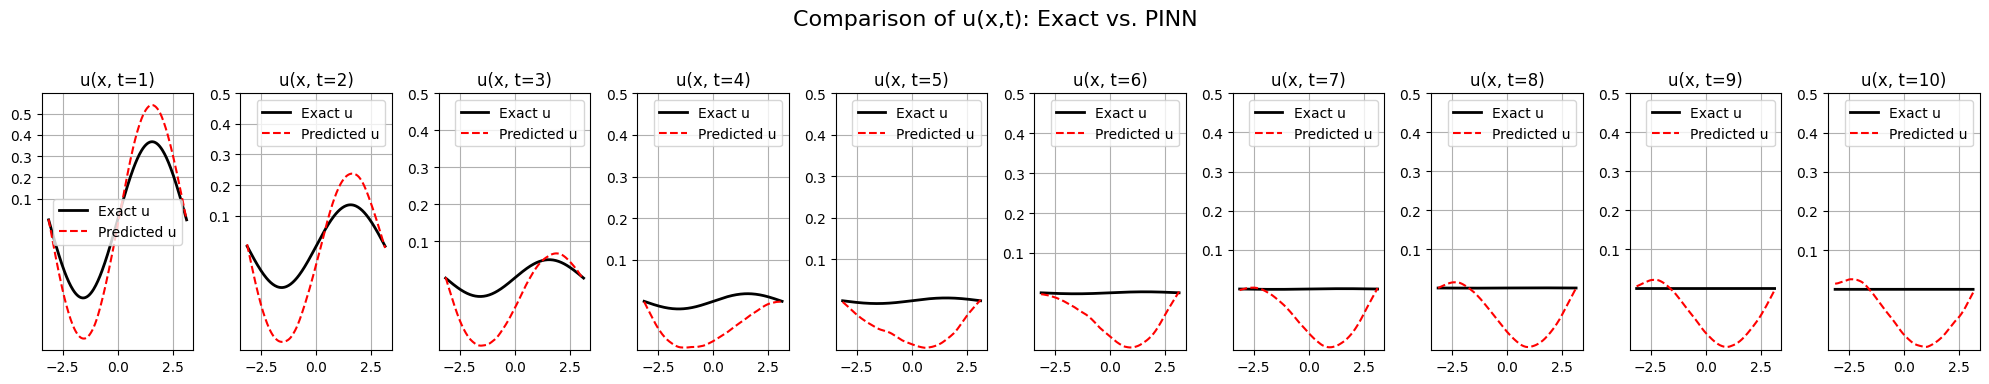

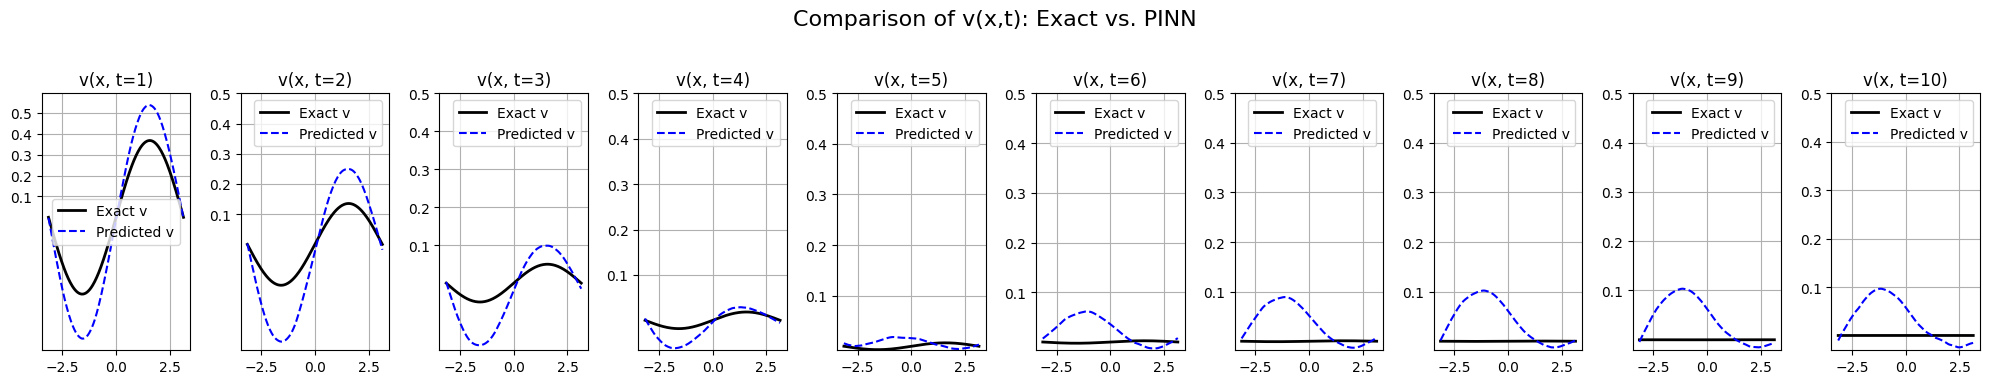

In [3]:
compare_pinn_vs_exact(model, t_values=[1,2,3,4,5,6,7,8,9,10])


In [4]:

def plot_results(x, u_pred, v_pred, u_exact, v_exact):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, u_exact, 'r', label='u_exact')
    plt.plot(x, u_pred, 'k--', label='u_pred')
    plt.title('u(x, t=1)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, v_exact, 'b', label='v_exact')
    plt.plot(x, v_pred, 'k--', label='v_pred')
    plt.title('v(x, t=1)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_error_metrics(model, t_eval=1.0, N_points=500):
    x = torch.linspace(xmin, xmax, N_points, device=device)
    t = torch.full_like(x, t_eval)
    X = torch.stack([t, x], dim=1)
    with torch.no_grad():
        u_pred, v_pred = model(X)
    u_true = u_exact(x, t)
    v_true = v_exact(x, t)

    u_err = torch.abs(u_pred.squeeze() - u_true)
    v_err = torch.abs(v_pred.squeeze() - v_true)

    u_Linf = u_err.max().item()
    u_L2 = torch.sqrt(torch.mean(u_err ** 2)).item()
    v_Linf = v_err.max().item()
    v_L2 = torch.sqrt(torch.mean(v_err ** 2)).item()

    print(f"\nError Metrics at t = {t_eval}")
    print(f"{'Metric':<12} {'u(x,t)':<12} {'v(x,t)':<12}")
    print(f"{'L_inf':<12} {u_Linf:<12.4e} {v_Linf:<12.4e}")
    print(f"{'L_2':<12} {u_L2:<12.4e} {v_L2:<12.4e}")

def save_plot(x, u_pred, v_pred, u_exact, v_exact, filename='pinn_plot_new_1.png'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, u_exact, 'r', label='u_exact')
    plt.plot(x, u_pred, 'k--', label='u_pred')
    plt.title('u(x, t=1)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, v_exact, 'b', label='v_exact')
    plt.plot(x, v_pred, 'k--', label='v_pred')
    plt.title('v(x, t=1)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"Plot saved as {filename}")

In [5]:
x, u_pred, v_pred, u_ex, v_ex = predict(model)


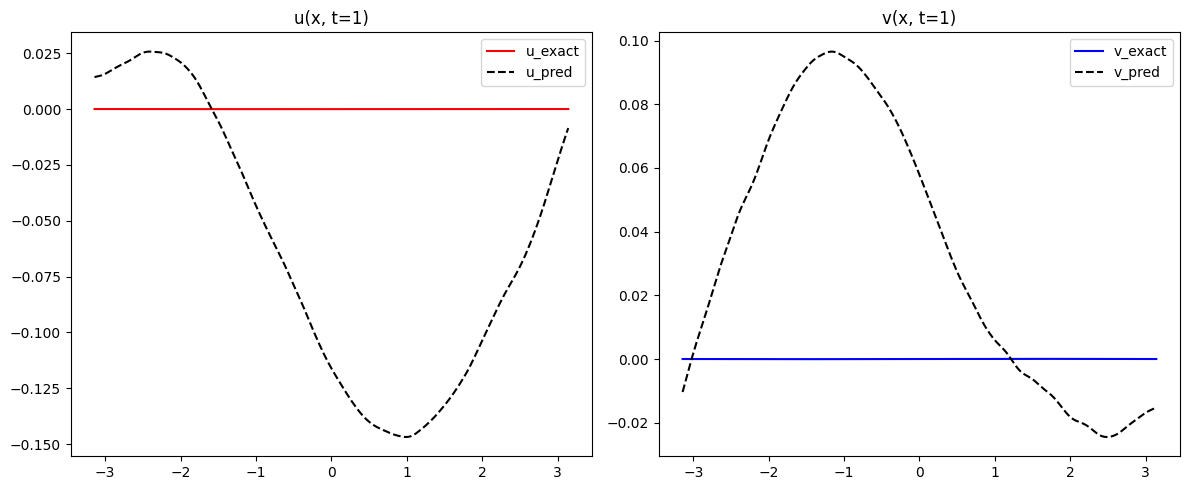

Plot saved as pinn_plot_new_1.png


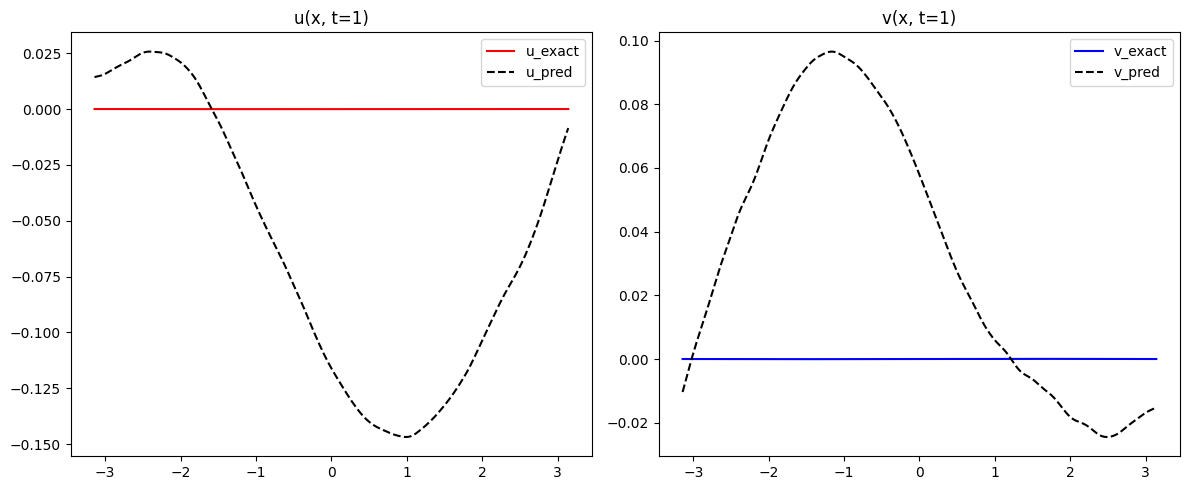

In [6]:
plot_results(x, u_pred, v_pred, u_ex, v_ex)
save_plot(x, u_pred, v_pred, u_ex, v_ex)


In [7]:
import pandas as pd

def collect_error_metrics(model, t_eval, N_points=500):
    x = torch.linspace(xmin, xmax, N_points, device=device)
    t = torch.full_like(x, t_eval)
    X = torch.stack([t, x], dim=1)
    with torch.no_grad():
        u_pred, v_pred = model(X)
        u_true = u_exact(x, t)
        v_true = v_exact(x, t)

    u_err = torch.abs(u_pred.squeeze() - u_true)
    v_err = torch.abs(v_pred.squeeze() - v_true)

    u_Linf = u_err.max().item()
    u_L2 = torch.sqrt(torch.mean(u_err ** 2)).item()
    v_Linf = v_err.max().item()
    v_L2 = torch.sqrt(torch.mean(v_err ** 2)).item()

    return u_Linf, u_L2, v_Linf, v_L2

def show_error_comparison_table(model):
    # Reference errors
    raslan = {
        0.5: (3.71443e-4, 6.59721e-4),
        1.0: (4.50721e-4, 8.00531e-4)
    }
    shallal = {
        0.5: (5.45633e-5, 4.1676e-5),
        1.0: (6.34602e-5, 4.4651e-5)
    }

    # Collect your model's errors
    data = []
    for t_val in [0.5, 1.0]:
        u_Linf, u_L2, v_Linf, v_L2 = collect_error_metrics(model, t_val)
        data.append({
            "t": t_val,
            "Raslan_Linf": raslan[t_val][0],
            "Raslan_L2": raslan[t_val][1],
            "Shallal_Linf": shallal[t_val][0],
            "Shallal_L2": shallal[t_val][1],
            "PINN_u_Linf": u_Linf,
            "PINN_u_L2": u_L2,
            "PINN_v_Linf": v_Linf,
            "PINN_v_L2": v_L2,
        })

    df = pd.DataFrame(data)
    pd.set_option('display.float_format', '{:.5e}'.format)
    display(df)

# Run the comparison table
show_error_comparison_table(model)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x2 and 10x100)